<a href="https://colab.research.google.com/github/nnajeh/Transfer_learning/blob/main/CT_classification_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title Import Libraries

In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim

import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#@title Load pretrained model

In [3]:
#load the weights that were used to classify images in the ImageNet
model = models.vgg16(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [4]:
# Display the summary of the vgg model
summary(model, torch.zeros(1,3,224,224));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

The pretrained model is composed of three modules: 
1. Features;
2. avgpool;
3. classifer

--> We will freeze the features and avgpool modules and modify the classifier according to our dataset


In [ ]:
#@title Prepare dataset: COVID/NON_COVID dataset


In [9]:
cd /content/drive/MyDrive/CT-Scans/COVID-CT/Images-processed

/content/drive/MyDrive/CT-Scans/COVID-CT/Images-processed


In [10]:
!unzip /content/drive/MyDrive/CT-Scans/COVID-CT/Images-processed/CT_COVID.zip

Archive:  /content/drive/MyDrive/CT-Scans/COVID-CT/Images-processed/CT_COVID.zip
   creating: CT_COVID/
  inflating: CT_COVID/2020.03.01.20029769-p21-73_1%1.png  
   creating: __MACOSX/
   creating: __MACOSX/CT_COVID/
  inflating: __MACOSX/CT_COVID/._2020.03.01.20029769-p21-73_1%1.png  
  inflating: CT_COVID/Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png  
  inflating: __MACOSX/CT_COVID/._Recurrence-of-positive-SARS-CoV-2-RNA-in-C_2020_International-Journal-of-Inf-p1-21%1.png  
  inflating: CT_COVID/2020.03.12.20034686-p17-91-4.png  
  inflating: __MACOSX/CT_COVID/._2020.03.12.20034686-p17-91-4.png  
  inflating: CT_COVID/2020.02.25.20021568-p24-111%8.png  
  inflating: __MACOSX/CT_COVID/._2020.02.25.20021568-p24-111%8.png  
  inflating: CT_COVID/2020.03.13.20035212-p23-153.png  
  inflating: __MACOSX/CT_COVID/._2020.03.13.20035212-p23-153.png  
  inflating: CT_COVID/2020.03.21.20040691-p18-6-6.png  
  inflating: __MACOSX/CT_COVID/._2020.03.21.

In [11]:
!unzip /content/drive/MyDrive/CT-Scans/COVID-CT/Images-processed/CT_NonCOVID.zip

Archive:  /content/drive/MyDrive/CT-Scans/COVID-CT/Images-processed/CT_NonCOVID.zip
  inflating: CT_NonCOVID/0.jpg       
  inflating: CT_NonCOVID/1%0.jpg     
  inflating: CT_NonCOVID/1%1.jpg     
  inflating: CT_NonCOVID/1%2.jpg     
  inflating: CT_NonCOVID/10%0.jpg    
  inflating: CT_NonCOVID/10%1.jpg    
  inflating: CT_NonCOVID/10%2.jpg    
  inflating: CT_NonCOVID/102.png     
  inflating: CT_NonCOVID/1029.png    
  inflating: CT_NonCOVID/103.png     
  inflating: CT_NonCOVID/1030.png    
  inflating: CT_NonCOVID/104.png     
  inflating: CT_NonCOVID/1046.png    
  inflating: CT_NonCOVID/1047.png    
  inflating: CT_NonCOVID/1048.png    
  inflating: CT_NonCOVID/1049.png    
  inflating: CT_NonCOVID/1050.png    
  inflating: CT_NonCOVID/1058.png    
  inflating: CT_NonCOVID/1059.png    
  inflating: CT_NonCOVID/1060.png    
  inflating: CT_NonCOVID/1061.png    
  inflating: CT_NonCOVID/1062.png    
  inflating: CT_NonCOVID/1065.png    
  inflating: CT_NonCOVID/1070.png    
  in

In [133]:
train_data_dir = '/content/drive/MyDrive/CT-Scans/COVID-CT/Images-processed/train'
test_data_dir = '/content/drive/MyDrive/CT-Scans/COVID-CT/Images-processed/test'

In [134]:
# Custom Dataset for COVID, NON_COVID Classification

class CTdata(Dataset):
  def __init__(self, folder):
    import glob
    covid = glob.glob(folder +'/CT_COVID/*.png')
    non_covid = glob.glob(folder+ '/CT_NonCOVID/*.png')

    self.fpaths = covid[:338] + non_covid[:380]
    self.normalize = transforms.Normalize(mean=[0.5,0.5, 0.5],std=[0.5, 0.5, 0.5])
    
    from random import shuffle, seed; seed(10);
    shuffle(self.fpaths)
    self.targets =[fpath.split('/')[-1].startswith('covid_') for fpath in self.fpaths]

  def __len__(self): 
    return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]

    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    im = torch.tensor(im/255)
    im = im.permute(2,0,1)
    im = self.normalize(im)

    return im.float().to(device),torch.tensor([target]).float().to(device)

In [135]:
data = CTdata(train_data_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.], device='cuda:0')


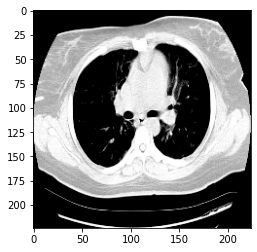

In [136]:
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
#@title Define the model


In [114]:
def get_model():
  model = models.vgg16(pretrained=True)
  # freeze all the parameters in the downloaded model
  for param in model.parameters():
    param.requires_grad = False
  
  # Replace the avgpool module to return a feature map of size 1 x 1 instead of 7 x 7, in other words, the output is now going to be batch_size x 512 x 1 x 1:
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  
  # Define the classifier
  model.classifier = nn.Sequential(nn.Flatten(),
                                 nn.Linear(512, 128),
                                 nn.ReLU(), nn.Dropout(0.2), nn.Linear(128, 1), nn.Sigmoid())

  # Define the loss function (loss_fn), optimizer
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(),lr= 1e-3)
  return model.to(device), loss_fn, optimizer


In [115]:
#summary the model
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [ ]:
#@title Train on a batch of data:



In [116]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  
  prediction = model(x)
  
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  
  optimizer.step()
  optimizer.zero_grad()
  
  return batch_loss.item()

In [117]:
# function to calculate accuracy on a batch of data:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  is_correct = (prediction > 0.5) == y
  return is_correct.cpu().numpy().tolist()

In [137]:
#Define a function to fetch the data loaders:
def get_data():
  train = CTdata(train_data_dir)
  trn_dl = DataLoader(train, batch_size=16, shuffle=True,  drop_last = True)
  
  val = CTdata(test_data_dir)
  val_dl = DataLoader(val, batch_size=16, shuffle=True, drop_last = True)
  return trn_dl, val_dl

In [139]:
#Initialize the get_data and get_model functions:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
#@title Train the model


In [ ]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    #val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    #for ix, batch in enumerate(iter(val_dl)):
     #   x, y = batch
      #  val_is_correct = accuracy(x, y, model)
       # val_epoch_accuracies.extend(val_is_correct)
   # val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    #val_accuracies.append(val_epoch_accuracy)

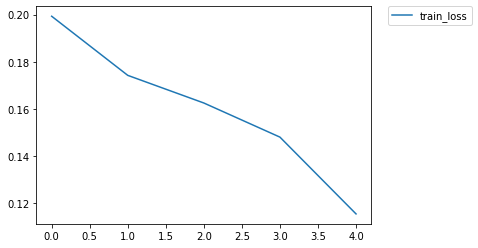

In [144]:
plt.plot(train_losses, label='train_loss')
#plt.plot(val_losses, label='val_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


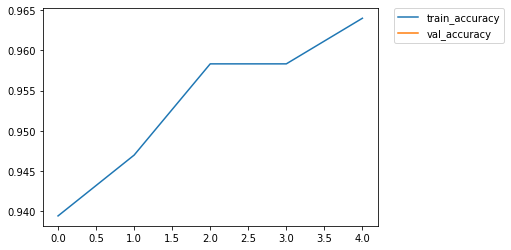

In [148]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(val_accuracies, label='val_accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()